## Using Tensorflow

In [1]:
import tensorflow as tf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

In [2]:
data_path = Path('../data')

In [3]:
train_df = pd.read_csv(data_path/'landmark_ds_train.csv')
test_df = pd.read_csv(data_path/'landmark_ds_test.csv')

In [4]:
def get_landmark_features(df):
  landmark_feature_names = df.columns[:-1]
  landmark_features = df[landmark_feature_names]
  # landmark_feature_tensors = tf.convert_to_tensor(landmark_features)
  return landmark_features
# get_landmark_features(train_df)

In [5]:
landmark_features = get_landmark_features(train_df) 
targets = train_df.IS_Y.values

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(landmark_features)

In [6]:
def f1_score(precision, recall):
    return 2 * precision * recall / (precision + recall)

In [7]:
from tensorflow.keras.metrics import Precision, Recall

model = tf.keras.Sequential([
  normalizer,
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dropout(.1),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[Precision(), Recall()])

In [8]:
history = model.fit(landmark_features, targets, epochs=30, batch_size=32, validation_split=.2)

Epoch 1/30
2888/2888 [==============================] - 3s 917us/step - loss: 0.2351 - precision: 0.7307 - recall: 0.1767 - val_loss: 0.1696 - val_precision: 0.8136 - val_recall: 0.4620
Epoch 2/30
2888/2888 [==============================] - 3s 876us/step - loss: 0.1320 - precision: 0.8624 - recall: 0.6314 - val_loss: 0.1128 - val_precision: 0.8460 - val_recall: 0.7643
Epoch 3/30
2888/2888 [==============================] - 2s 846us/step - loss: 0.0934 - precision: 0.9031 - recall: 0.7896 - val_loss: 0.0870 - val_precision: 0.9018 - val_recall: 0.8164
Epoch 4/30
2888/2888 [==============================] - 2s 861us/step - loss: 0.0770 - precision: 0.9198 - recall: 0.8400 - val_loss: 0.0748 - val_precision: 0.9138 - val_recall: 0.8479
Epoch 5/30
2888/2888 [==============================] - 2s 850us/step - loss: 0.0676 - precision: 0.9290 - recall: 0.8716 - val_loss: 0.0673 - val_precision: 0.9209 - val_recall: 0.8702
Epoch 6/30
2888/2888 [==============================] - 2s 863us/step 

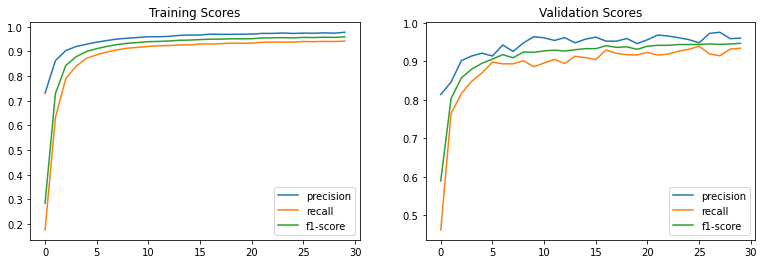

In [9]:
precision = np.array(history.history['precision'])
recall = np.array(history.history['recall'])
val_precision = np.array(history.history['val_precision'])
val_recall = np.array(history.history['val_recall'])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 4))
ax1.plot(precision)
ax1.plot(recall)
ax1.plot(f1_score(precision, recall))
ax1.legend(['precision', 'recall', 'f1-score'])
ax1.set_title("Training Scores")

ax2.plot(val_precision)
ax2.plot(val_recall)
ax2.plot(f1_score(val_precision, val_recall))
ax2.legend(['precision', 'recall', 'f1-score'])
ax2.set_title("Validation Scores")

plt.show()

In [13]:
test_loss, test_precision, test_recall = model.evaluate(get_landmark_features(test_df), test_df.IS_Y.values, verbose=2)
test_loss, test_precision, test_recall, f1_score(test_precision, test_recall)

903/903 - 0s - loss: 0.0320 - precision: 0.9603 - recall: 0.9486 - 375ms/epoch - 415us/step


(0.032048195600509644, 0.96030592918396, 0.9485611319541931, 0.954397399121063)

In [14]:
model.save('landmark-classifier')

INFO:tensorflow:Assets written to: landmark-classifier\assets


In [12]:
# !zip -r landmark_classifier.zip landmark-classifier/